## Getting the data
We obtain the data using Google Big Query.
In order to obtain the deposits and withdrawals transactions, just run the following querys:

### Withdrawals 
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE `to_address` 
IN (SELECT `address` FROM `tornado_cash_transactions.tornadocontracts`) AND SUBSTR(`input`, 1, 10) = "0x21a0adb6";

### Deposits
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE `to_address` 
IN (SELECT `address` FROM `tornado_cash_transactions.tornadocontracts`) AND SUBSTR(`input`, 1, 10) = "0xb214faa5";

References here:
https://github.com/Phread420/tornado_bigquery/blob/main/Notes.md

This results are stored in the following files:
- withdraw_transactions.csv
- deposit_transactions.csv

After obtaining those two files, the next thing to do is to get the "recipient_addresses" that are making the withdrawl (if the user withdraws via a relayer, the relayer's account will be displayed in the "from_addres" field). That information is encoded in the "input" field of the withdrawal transactions.

The process to do so is in the following notebook:
https://github.com/lambdaclass/tornado_cash_anonymity_tool/blob/main/notebooks/complete_withdraw_data_set.ipynb

Note that the recipient addresses obtained in this df are in upper case and the addresses coming from the big query are in lower case, so you have to make the transformation when running the heuristic.

## Second heuristic - Preliminary implementation

### Description

If there is a deposit and a withdraw transaction with **unique** gas prices (e.g., 3.1415926 Gwei), then we consider the deposit and the withdraw transactions linked. The corresponding deposit transaction can be removed from any other withdraw transaction’s anonymity set.

In [54]:
# Import relevant packages
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load transactions data

withdraw_transactions_df = pd.read_csv("../data/lighter_complete_withdraw_txs.csv")
# Change recipient_address to lowercase.
withdraw_transactions_df["recipient_address"] = withdraw_transactions_df["recipient_address"].str.lower()
# Change block_timestamp field to be a timestamp object.
withdraw_transactions_df["block_timestamp"] = withdraw_transactions_df["block_timestamp"].apply(pd.Timestamp)

non_relayer_withdraw_transactions_df = withdraw_transactions_df[withdraw_transactions_df["from_address"]==withdraw_transactions_df["recipient_address"]]

deposit_transactions_df = pd.read_csv("../data/lighter_complete_deposit_txs.csv")
# Change block_timestamp field to be a timestamp object.
deposit_transactions_df["block_timestamp"] = deposit_transactions_df["block_timestamp"].apply(pd.Timestamp)

# tornado_addresses = pd.read_csv("../data/tornadocontracts_abi.csv", names=['address', 'contract_currency', 'value', '4'])

### Function summary: filter_by_unique_gas_price

Given a transactions DataFrame, it returns a dictionary with the unique gas prices as keys and a tuple containing the hash of that transaction and the timestamp. For example,

```
{111000302: ("0x387fcd87a", timestamp1)
```

In [3]:
def filter_by_unique_gas_price(transactions_df):
    
    # Count the appearances of each gas price in the transactions DataFrame.
    
    gas_prices_count = transactions_df["gas_price"].value_counts()
    
    # Filter the gas prices that are unique, i.e., the ones with a count equal to 1.
    # The gas prices are stored in unique_gas_prices
    
    unique_gas_prices = gas_prices_count[gas_prices_count == 1].keys()
    
    # A dataframe of the transactions that verify having these unique gas price values.
    
    temp_df = transactions_df[transactions_df["gas_price"].isin(unique_gas_prices)]
    
    # The DataFrame is transformed to a dictionary with only the relevant information.
    
    return {row.gas_price: (row.hash, row.block_timestamp) for row in temp_df.itertuples()}

### Function summary: filter_by_unique_gas_price_by_pool

Given a transactions DataFrame, it returns a dictionary with a tuple of the unique gas prices and tornado pool as keys and a tuple containing the hash of that transaction and the timestamp. For example, 

```
{(111000302, "0x24387248"): ("0x387fcd87a", timestamp1)

```

In [4]:
def filter_by_unique_gas_price_by_pool(transactions_df):
    
    # Count the appearances of each gas price by pool in the transactions DataFrame.
    
    gas_prices_count = deposit_transactions_df[["gas_price", "tornado_cash_address"]].value_counts()
    
    '''
    Filter the gas prices that are unique for each pool, i.e., the ones with a count equal to 1.
    The gas prices are stored in unique_gas_prices
    '''
    
    unique_gas_prices_by_pool = pd.DataFrame(gas_prices_count[gas_prices_count == 1])
    
    # Tuple set with the values (gas_price, tornado_cash_address) is made to filter efficiently
    
    tuple_set = set([(row.Index[0], row.Index[1]) for row in unique_gas_prices_by_pool.itertuples()])
    
    # A dataframe of the transactions that verify having these unique gas price values by pool.
    
    temp_df = pd.DataFrame(filter(lambda iter_tuple: (iter_tuple.gas_price, iter_tuple.tornado_cash_address) in tuple_set, deposit_transactions_df.itertuples()))
    
    # The DataFrame is transformed to a dictionary with only the relevant information.
    
    return {(row.gas_price, row.tornado_cash_address): (row.hash, row.block_timestamp) for row in temp_df.itertuples()}

A test of the function applied to our deposit transactions data.

### Function summary: same_gas_price_heuristic

This function receives a particular withdraw transaction and a dictionary with the unique gas price deposits, as returned by the function filter_by_unique_gas_price.

It returns a tuple:
* $(True, deposit$ $hash)$ when a deposit transaction with the same gas price as the withdrawal transaction is found.
* $(False, None)$ when such a deposit is not found.

In [5]:
def same_gas_price_heuristic(withdrawal_transaction, unique_gas_price_deposit_dict):
    
    '''
    Check if the gas price of the given withdrawal transaction is within the dictionary keys and that
    the deposit was made earlier than the withdral.
    If it is, then a tuple is returned, (True, deposit_hash).
    If it is not, (False, None) is returned.
    '''
    
    if withdrawal_transaction.gas_price in set(unique_gas_price_deposit_dict.keys()) and (unique_gas_price_deposit_dict[withdrawal_transaction.gas_price][1] < withdrawal_transaction.block_timestamp):
        return (True, unique_gas_price_deposit_dict[withdrawal_transaction.gas_price][0])
    else:   
        return (False, None)

### Function summary: same_gas_price_heuristic_by_pool

This function receives a particular withdraw transaction and a dictionary with the unique gas price deposits made in each pool, just as returned by the function filter_by_unique_gas_price_by_pool.

It returns a tuple:
* $(True, deposit$ $hash)$ when a deposit transaction with the same gas price and belonging from the same pool (for example, 1ETH) as the withdrawal transaction is found.
* $(False, None)$ when such a deposit is not found.

In [6]:
def same_gas_price_heuristic_by_pool(withdrawal_transaction, unique_gas_price_deposit_dict):
    
    '''
    Check if the pair (gas_price, tornado_pool) of the given withdrawal transaction is within the dictionary keys and that
    the deposit was made earlier than the withdral.
    If it is, then a tuple is returned, (True, deposit_hash).
    If it is not, (False, None) is returned.
    '''
    
    if (withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address) in set(unique_gas_price_deposit_dict.keys()) and (unique_gas_price_deposit_dict[(withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address)][1] < withdrawal_transaction.block_timestamp):
        return (True, unique_gas_price_deposit_dict[(withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address)][0])
    else:   
        return (False, None)

### Function summary: apply_same_gas_price_heuristic

Applies the heuristic to all the withdraw_transactions DataFrame. Returns a dicionary mapping linked withdrawal and deposit transaction hashes.

In [7]:
def apply_same_gas_price_heuristic(deposit_transactions_df, withdraw_transactions_df):
    
    # Get deposit transactions with unique gas prices.
    
    unique_gas_price_deposits_dict = filter_by_unique_gas_price(deposit_transactions_df)
    
    # Initialize an empty dictionary to store the linked transactions.
    
    withdrawal_to_deposit = {}
    
    # Iterate over the withdraw transactions.
    for withdraw_row in tqdm(withdraw_transactions_df.itertuples(), total=withdraw_transactions_df.shape[0], mininterval=10):     
        # Apply heuristic for the given withdraw transaction.
        same_gas_deposit_hash = same_gas_price_heuristic(withdraw_row, unique_gas_price_deposits_dict)
        
        # When a deposit transaction matching the withdraw transaction gas price is found, add
        # the linked transactions to the dictionary.
        if same_gas_deposit_hash[0]:
            withdrawal_to_deposit[withdraw_row.hash] = same_gas_deposit_hash[1]

    # Return the linked transactions dictionary.
    return withdrawal_to_deposit

### Function summary: apply_same_gas_price_heuristic_by_pool

Applies the heuristic to all the withdraw_transactions DataFrame, filtering also by the particular pool. Returns a dicionary mapping linked withdrawal and deposit transaction hashes.

In [8]:
def apply_same_gas_price_heuristic_by_pool(deposit_transactions_df, withdraw_transactions_df):
    
    # Get deposit transactions with unique gas prices.
    
    unique_gas_price_deposits_dict = filter_by_unique_gas_price_by_pool(deposit_transactions_df)
    
    # Initialize an empty dictionary to store the linked transactions.
    
    withdrawal_to_deposit = {}
    
    # Iterate over the withdraw transactions.
    for withdraw_row in tqdm(withdraw_transactions_df.itertuples(), total=withdraw_transactions_df.shape[0], mininterval=10):     
        # Apply heuristic for the given withdraw transaction.
        same_gas_deposit_hash = same_gas_price_heuristic_by_pool(withdraw_row, unique_gas_price_deposits_dict)
        
        # When a deposit transaction matching the withdraw transaction gas price is found, add
        # the linked transactions to the dictionary.
        if same_gas_deposit_hash[0]:
            withdrawal_to_deposit[withdraw_row.hash] = same_gas_deposit_hash[1]

    # Return the linked transactions dictionary.
    return withdrawal_to_deposit

We run the heuristic for the entire withdraw dataset

In [9]:
linked_transactions = apply_same_gas_price_heuristic(deposit_transactions_df, non_relayer_withdraw_transactions_df)

100%|██████████| 17037/17037 [00:09<00:00, 1759.44it/s]


In [10]:
linked_transactions = pd.DataFrame.from_dict({"withdraw_hashes": linked_transactions.keys(), "deposit_hashes": linked_transactions.values()})
linked_transactions

,withdraw_hashes,deposit_hashes
0,0xb07d06c8ca80ce4052954393d79b2f95d83034607d15...,0xbcd359d0323dc74c7a246d98cae706c75a6b3b518203...
1,0xbace5d33d2ce99ea408a03924846f4f5bc47b5125be3...,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e6...
2,0x99b09453c62a24b9b7f78c27b37d1c06c2b9a6428541...,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e6...
3,0xa0b96bec4615aad1d3c79871316cadd13f0b632e95ad...,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e6...
4,0x02f760cf72499455028fd5f99ccb0d8d8b56a637c5d2...,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e6...
...,...,...
123,0x9668053f20bc95ef17dc427ef913883cefc0a639bbc2...,0x0360baaa220ad16d11edc64123f17dbdbc5547904d50...
124,0x73fd2f663dc86d8bb252726dc7cbf9af5ff6eb786a0e...,0xb61a3104f74c1af05c8b8742288da600cee5744ad4af...
125,0x155c67c52f442d8e311f8dcfeb802db1fe0539c8b624...,0xfde60cd9b4b53885ae6bdc1ac39b5760232634a595e7...
126,0x92af7fcb7e26b1fbaf166347f144f4ed2b536c3724e1...,0x79ae9cc02ab3a954ad50bcedce6761ab4d7ea4760361...


Now we run the heuristic that filters by pool, again applying it to the entire withdraw dataset.

In [11]:
linked_transactions_by_pool = apply_same_gas_price_heuristic_by_pool(deposit_transactions_df, non_relayer_withdraw_transactions_df)

100%|██████████| 17037/17037 [00:12<00:00, 1362.36it/s]


In [12]:
linked_transactions_by_pool_df = pd.DataFrame.from_dict({"withdraw_hashes": linked_transactions_by_pool.keys(), "deposit_hashes": linked_transactions_by_pool.values()})
linked_transactions_by_pool_df

,withdraw_hashes,deposit_hashes
0,0xda1eb6593a724f270d6668932f874546a0e98317ff76...,0xd382985d27002cbd8c803b324a42dcc93e39955fb9a4...
1,0x67586876b52286e9b976ace3edd9b79c4e8a75b0e912...,0x195fd8c20dacb7bb4c6e4b68a440df384473052bc39e...
2,0x1135c0eded88540534712a824bda2b906a3f6d6106da...,0xba7d56fea776705a937d912674cc56cf3ea71485c8fb...
3,0xc2ee3f975d14c5d1f57e2381414ea092df1eda2d0e2f...,0xba7d56fea776705a937d912674cc56cf3ea71485c8fb...
4,0x039c04c3d40dc1e1ef9b1108905e5aeceb82e05a0d4e...,0xdeaa7d1eaf4cfeedbc4496e85c1f3cb7f7ca3471e2c1...
...,...,...
167,0x4611c3b8eb6b90d267295aa822878a4200e5257fa381...,0x1af19bf59b0a2c3877a784d7c0e9d879e0550236bb25...
168,0x88e3e2d091efaa07f3ca7bae94d7cd6314ca68127d6b...,0x773d0041752549dbffa735b3a5778746789adcdce51b...
169,0x2516a26c3ff0a0583c72b9b5666c36370789843ff85e...,0x658be4fc6bf021744611067c36319be83f49f011fa7a...
170,0x9e1a17c0286f15358687ae7cb4f206ccfa14a08b5384...,0x1cdf20fc3fcf4ef61a3e3e45e579611e1070a0de8771...


In [61]:
timestamps = []
for i in tqdm(range(len(linked_transactions_by_pool_df))):
    depositTimestamp = datetime.timestamp(deposit_transactions_df.loc[deposit_transactions_df['hash'] == linked_transactions_by_pool_df['deposit_hashes'][i]]['block_timestamp'].item())
    withdrawTimestamp = datetime.timestamp(withdraw_transactions_df.loc[withdraw_transactions_df['hash'] == linked_transactions_by_pool_df['withdraw_hashes'][i]]['block_timestamp'].item()) 
    timestamps.append(withdrawTimestamp-depositTimestamp)
timestamps = [timestamp/8640000 for timestamp in timestamps]   

100%|██████████| 172/172 [00:03<00:00, 54.87it/s]


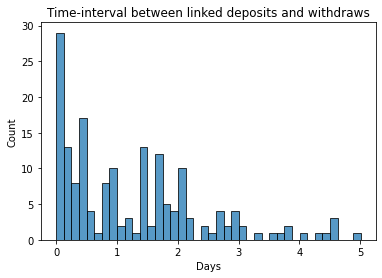

In [62]:
sns.histplot(timestamps,bins=40)
plt.xlabel("Days")
plt.title("Time-interval between linked deposits and withdraws")
plt.show()